In [1]:
# a demonstration of use of the logistic regression classifier 
# for content classification on doc2vec docs vectors
# where logit probabilities of the classified content against the given categories can be used as relevance rating
# towards the classified categories

# references:
# [1] https://deeplearning4j.org/word2vec.html
# [2] http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# [3] http://scikit-learn.org/stable/modules/cross_validation.html

# author Michal Stefanik  mistefan  at  redhat dot com

import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.estimators.estimator import SKCompat

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# D2VWrapper is our implementation providing vectorization of the documents based on doc2vec
from doc2vec_wrapper import D2VWrapper

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# optimization steps are reduced on TEST_MODE
TEST_MODE = False

# target categories
product_list = ["amq", "eap", "webserver", "datagrid", "fuse", "brms", "bpmsuite", "devstudio", "cdk",
                "developertoolset", "rhel", "softwarecollections", "mobileplatform", "openshift"]

In [3]:
# extended evaluation metric on selected category
def accuracy_for_category(y_expected, y_actual, label):
    label_expected = y_expected[y_expected == label]
    intersect = y_expected[np.where(y_expected == y_actual)]
    label_intersect = intersect[intersect == label]
    if len(label_expected) == 0:
        logging.warn("Accuracy of %s category evaluated on 0 samples" % label)
        return 1 if len(label_intersect) == 0 else 0
    else:
        return float(len(label_intersect)) / len(label_expected)

In [4]:
# initialize d2v_wrapper providing as well metadata about the models state
d2v_wrapper = D2VWrapper(content_categories=product_list,
                         vector_length=500)

# EITHER initialize the vocab of documents and minimize the distances of embeddings in training phase
d2v_wrapper.init_model_vocab(content_basepath="../../data/content/playground/auto/nostem",
                             basepath_suffix="_content.csv", drop_short_docs=10)
d2v_wrapper.train_model(shuffle=True, epochs=1 if TEST_MODE else 10)

# OR load initialized and trained wrapper if available
# d2v_wrapper.load_persisted_wrapper("trained_models/wrapper/100epoch_train_nostem")

2017-04-17 14:36:33,153 : INFO : Loaded 51488 docs from 14 categories
2017-04-17 14:36:33,154 : INFO : Filtering docs shorter than 10 tokens from vocab sample
2017-04-17 14:36:33,177 : INFO : 43478 docs included in vocab init
2017-04-17 14:36:35,341 : INFO : collecting all words and their counts
2017-04-17 14:36:35,342 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-04-17 14:36:35,592 : INFO : PROGRESS: at example #10000, processed 1462558 words (5865267/s), 41870 word types, 10000 tags
2017-04-17 14:36:35,863 : INFO : PROGRESS: at example #20000, processed 3020434 words (5761593/s), 69836 word types, 20000 tags
2017-04-17 14:36:36,104 : INFO : PROGRESS: at example #30000, processed 4504158 words (6226047/s), 84891 word types, 30000 tags
2017-04-17 14:36:36,254 : INFO : PROGRESS: at example #40000, processed 5491887 words (6590481/s), 97103 word types, 40000 tags
2017-04-17 14:36:36,329 : INFO : collected 104005 word types and 43478 unique tags from

In [5]:
doc_vectors_labeled = d2v_wrapper.infer_content_vectors()

2017-04-17 14:50:42,803 : INFO : Docs vector inference started
2017-04-17 14:50:42,804 : INFO : Inferring vectors of 43478 documents


In [6]:
d2v_wrapper.persist_trained_wrapper(model_save_path="trained_models/wrapper/10epoch_train_stem_not_removed")

2017-04-17 14:56:48,127 : INFO : Serializing wrapper model to: trained_models/wrapper/10epoch_train_stem_not_removed
2017-04-17 14:56:48,128 : INFO : Persisting docs objects
2017-04-17 14:56:56,622 : INFO : Persisting inferred vectors
2017-04-17 14:57:13,319 : INFO : Persisting trained Doc2Vec model
2017-04-17 14:57:13,320 : INFO : saving Doc2Vec object under trained_models/wrapper/10epoch_train_stem_not_removeddoc2vec.mod, separately None
2017-04-17 14:57:13,321 : INFO : storing numpy array 'doctag_syn0' to trained_models/wrapper/10epoch_train_stem_not_removeddoc2vec.mod.docvecs.doctag_syn0.npy
2017-04-17 14:57:14,122 : INFO : storing numpy array 'syn1neg' to trained_models/wrapper/10epoch_train_stem_not_removeddoc2vec.mod.syn1neg.npy
2017-04-17 14:57:14,152 : INFO : not storing attribute syn0norm
2017-04-17 14:57:14,153 : INFO : storing numpy array 'syn0' to trained_models/wrapper/10epoch_train_stem_not_removeddoc2vec.mod.syn0.npy
2017-04-17 14:57:14,212 : INFO : not storing attribut

In [7]:
# transform the doc data set into a vector set of the given vector_length
# doc_vectors_labeled = d2v_wrapper.infer_content_vectors()
doc_vectors = doc_vectors_labeled.iloc[:, :-1]
doc_labels = doc_vectors_labeled.iloc[:, -1]

In [8]:
doc_labels.describe()

count     43478
unique       14
top         eap
freq      18302
Name: y, dtype: object

In [9]:
# limit the content to specific categories
# limit_prod_list = ["webserver", "datagrid", "fuse", "brms"]
# doc_vectors = doc_vectors[doc_labels.isin(limit_prod_list)]
# doc_labels = doc_labels[doc_labels.isin(limit_prod_list)]
# doc_vectors.describe()

In [10]:
# classifier training and eval:
from sklearn.linear_model import LogisticRegression

# results collection
accuracies = []
cat_accuracies = pd.DataFrame(columns=d2v_wrapper.content_categories)
logits = pd.DataFrame(columns=["actual_prob", "expected_prob", "actual_class", "expected_class"])
wrong_docs_ids = pd.Series()

# evaluation on CV split persisting the categories respective size on each split
strat_kfold = StratifiedKFold(n_splits=2 if TEST_MODE else 5, shuffle=True)

for train_doc_indices, test_doc_indices in strat_kfold.split(doc_vectors, doc_labels):

    random.shuffle(train_doc_indices)
    random.shuffle(test_doc_indices)
    
    # training
    logging.info("Fitting classifier")
    log_reg_classifier = LogisticRegression(C=0.3, solver="sag", multi_class='ovr', n_jobs=8, max_iter=1000)
    log_reg_classifier.fit(doc_vectors.iloc[train_doc_indices], doc_labels.iloc[train_doc_indices])
    
    # testing
    logging.info("Predicting")
    y_expected = doc_labels.iloc[test_doc_indices].values
    y_actual = log_reg_classifier.predict(doc_vectors.iloc[test_doc_indices])
    
    # evaluation:
    # logits
    logging.info("Probs collection")
    class_probs = log_reg_classifier.predict_proba(doc_vectors.iloc[test_doc_indices])
    class_ordered = list(log_reg_classifier.classes_)
    
    class_actual_index = pd.Series(y_actual).apply(lambda cat_label: class_ordered.index(cat_label))
    actual_prob = class_probs[np.arange(len(class_actual_index)),(class_actual_index)]
    
    class_expected_index = pd.Series(y_expected).apply(lambda cat_label: class_ordered.index(cat_label))
    expected_prob = class_probs[np.arange(len(class_actual_index)),(class_expected_index)]
    
    new_logits = pd.DataFrame()
    new_logits["doc_id"] = test_doc_indices
    new_logits["actual_prob"] = actual_prob
    new_logits["expected_prob"] = expected_prob
    new_logits["actual_class"] = y_actual
    new_logits["expected_class"] = y_expected
    logits = logits.append(new_logits)
    
    # accuracy
    logging.info("Split results:")
    split_accuracy = accuracy_score(y_expected, y_actual)
    logging.info("Run accuracy: %s" % split_accuracy)
    accuracies.append(split_accuracy)
    split_cat_accuracies = map(lambda cat: accuracy_for_category(y_expected, y_actual, cat),
                               d2v_wrapper.content_categories)
    logging.info("Cat accuracies:\n%s" % split_cat_accuracies)
    cat_accuracies = cat_accuracies.append(
        pd.DataFrame(data=[split_cat_accuracies], columns=d2v_wrapper.content_categories))
    
    # misclassified docs collection
    wrong_docs_ids = wrong_docs_ids.append(pd.Series(test_doc_indices[y_actual != y_expected]))

2017-04-17 14:57:19,293 : INFO : Fitting classifier
2017-04-17 14:58:25,012 : INFO : Predicting
2017-04-17 14:58:25,119 : INFO : Probs collection
2017-04-17 14:58:25,244 : INFO : Split results:
2017-04-17 14:58:25,250 : INFO : Run accuracy: 0.84233509538
2017-04-17 14:58:25,256 : INFO : Cat accuracies:
[0.17557251908396945, 0.9396339797869434, 0.265625, 0.3492063492063492, 0.861207494795281, 0.41911764705882354, 0.5111111111111111, 0.7807407407407407, 0.06666666666666667, 0.0, 0.9324635456638527, 0.0, 0.3333333333333333, 0.821173104434907]
2017-04-17 14:58:25,280 : INFO : Fitting classifier
2017-04-17 14:59:33,314 : INFO : Predicting
2017-04-17 14:59:33,429 : INFO : Probs collection
2017-04-17 14:59:33,554 : INFO : Split results:
2017-04-17 14:59:33,561 : INFO : Run accuracy: 0.840901253018
2017-04-17 14:59:33,568 : INFO : Cat accuracies:
[0.22137404580152673, 0.9396339797869434, 0.28272251308900526, 0.2698412698412698, 0.8521859819569744, 0.40808823529411764, 0.4533333333333333, 0.783

In [11]:
logging.info("split accuracies: %s" % accuracies)
logging.info("mean accuracy: %s" % np.mean(accuracies))
logging.info("categories accuracies: \n%s" % cat_accuracies)
logging.info("categories accuracies mean: \n%s" % cat_accuracies.mean())
logging.info("done")

2017-04-17 15:02:52,728 : INFO : split accuracies: [0.84233509538037232, 0.84090125301758822, 0.84508338125359406, 0.84456971928209845, 0.84533947065592641]
2017-04-17 15:02:52,729 : INFO : mean accuracy: 0.843645783918
2017-04-17 15:02:52,738 : INFO : categories accuracies: 
        amq       eap  webserver  datagrid      fuse      brms  bpmsuite  \
0  0.175573  0.939634   0.265625  0.349206  0.861207  0.419118  0.511111   
0  0.221374  0.939634   0.282723  0.269841  0.852186  0.408088  0.453333   
0  0.259542  0.936339   0.298429  0.396825  0.850104  0.393382  0.537778   
0  0.290076  0.935519   0.324607  0.365079  0.859126  0.383764  0.540179   
0  0.192308  0.934426   0.267016  0.290323  0.857738  0.391144  0.517857   

   devstudio       cdk  developertoolset      rhel  softwarecollections  \
0   0.780741  0.066667               0.0  0.932464                  0.0   
0   0.783704  0.066667               0.0  0.924731                  0.0   
0   0.777778  0.000000               0.0 

In [12]:
# accuracies of categories together with their size

labels_size = pd.DataFrame()
labels_size["label"] = doc_labels.unique()
labels_size["accuracy"] = cat_accuracies.mean().values
labels_size["size"] = [len(doc_labels[doc_labels == cat]) for cat in labels_size["label"]]
labels_size = labels_size.sort_values(by=["size"])

labels_size

,label,accuracy,size
11,softwarecollections,0.000000,5
9,developertoolset,0.000000,12
8,cdk,0.083810,72
12,mobileplatform,0.376667,101
3,datagrid,0.334255,314
0,amq,0.227775,654
2,webserver,0.287680,956
6,bpmsuite,0.512052,1123
5,brms,0.399099,1358
7,devstudio,0.783578,3373


In [13]:
# computed actual_prob probabilities might be used as ranking system of the relevance of documents towards categories
logits["doc_id"] = logits["doc_id"].apply(lambda x: int(x))
logits = logits.set_index("doc_id")
logits.head(25)

,actual_class,actual_prob,expected_class,expected_prob
doc_id,,,,
9692,eap,0.637559,eap,0.637559
10835,eap,0.963471,eap,0.963471
14392,eap,0.925623,eap,0.925623
42275,openshift,0.805400,openshift,0.805400
34225,rhel,0.947918,rhel,0.947918
30600,devstudio,0.617149,devstudio,0.617149
27306,fuse,0.869426,fuse,0.869426
37864,rhel,0.942419,rhel,0.942419
11958,eap,0.868466,eap,0.868466


In [14]:
biggest_cats = labels_size["label"][-6:]
biggest_cats_df = logits[logits["expected_class"].isin(biggest_cats)]
biggest_cats_df["expected_class"].unique()

array(['eap', 'openshift', 'rhel', 'devstudio', 'fuse', 'brms'], dtype=object)

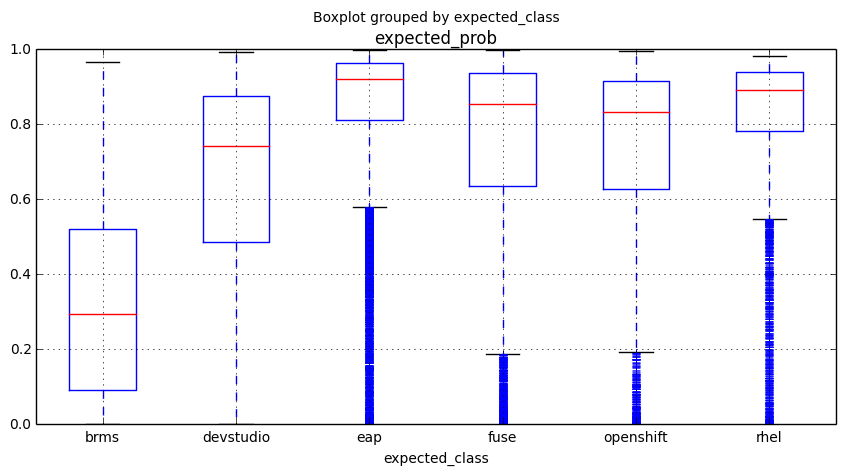

In [15]:
# boxplot visualization of the scores of documents against its own category (biggest 6 classes)
# the higher the better
# we see that it goes much better for bigger categories

# boxplot: 50% of data in box, 90% in dashed intervals
%matplotlib inline
import matplotlib.pyplot as plt

join_label_size = labels_size
join_label_size["expected_class"] = join_label_size["label"]

biggest_cats_df.boxplot("expected_prob", by="expected_class", figsize=(10,5))

In [16]:
# incorrect classification characteristics
wrong_docs_ids = pd.Series(logits[logits["expected_class"] != logits["actual_class"]].index)

wrong_docs_wordlist = wrong_docs_ids.apply(lambda doc_id: d2v_wrapper.get_doc_content(int(doc_id), word_split=True))
wrong_docs_len = wrong_docs_wordlist.apply(lambda doc: len(doc))
wrong_docs_len.describe()

count     6798.000000
mean       146.269197
std       1037.559489
min         10.000000
25%         19.000000
50%         32.000000
75%         75.000000
max      79212.000000
Name: doc_id, dtype: float64

In [17]:
# correct classification characteristics
all_indices = pd.Series(np.arange(len(doc_vectors)))
correct_docs =  all_indices[~all_indices.isin(wrong_docs_ids)]
# data need to be indexed incrementally for later plotting
correct_docs.index=np.arange(len(correct_docs))
correct_docs_wordlist = correct_docs.apply(lambda doc_id: d2v_wrapper.get_doc_content(doc_id, word_split=True))
correct_docs_len = correct_docs_wordlist.apply(lambda doc: len(doc))

correct_docs_len.describe()

count    36680.000000
mean       135.698119
std        485.596118
min         10.000000
25%         26.000000
50%         41.000000
75%        105.000000
max      56006.000000
dtype: float64

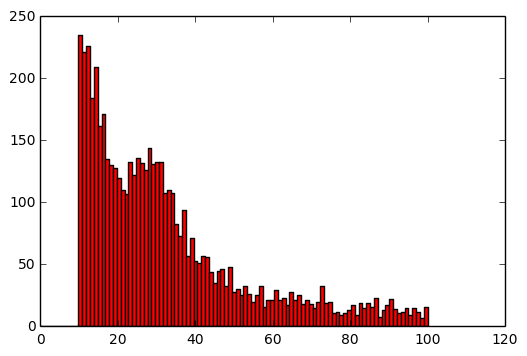

In [18]:
# missclassified docs length distribution
bordering_q = 0.8
bordering_q_value = int(wrong_docs_len.quantile(q=bordering_q))
plt.hist(wrong_docs_len, bins=bordering_q_value+1, range=(0, bordering_q_value), color="r")
plt.show()

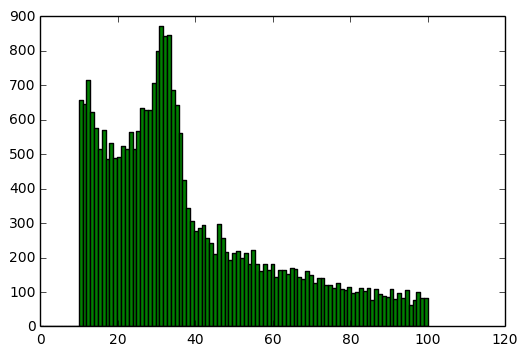

In [19]:
# correctly classified length distribution
plt.hist(correct_docs_len, bins=bordering_q_value+1, range=(0, bordering_q_value), color="g")
plt.show()

<Container object of 100 artists>

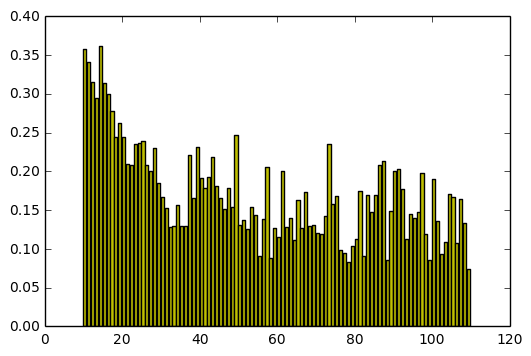

In [20]:
# distribution of incorrectly/correctly classified ratio by docs length
doc_len_error = (wrong_docs_len.value_counts() / correct_docs_len.value_counts())
ploted_doc_len_error = doc_len_error[:bordering_q_value]

plt.bar(ploted_doc_len_error.index, ploted_doc_len_error, color="y")

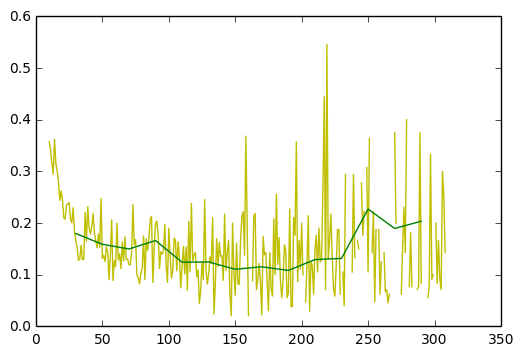

In [26]:
error_plot_border = 300
error_ploted = doc_len_error[:error_plot_border]
plt.plot(error_ploted.index, error_ploted, color="y")
mean_range = 20

mean_plot_ids = range(mean_range, error_plot_border+mean_range, mean_range)
mean_plot_vals = map(lambda mean_id: error_ploted.iloc[mean_id-5-mean_range: mean_id+5-mean_range].mean(), mean_plot_ids)
mean_plot = pd.Series(mean_plot_vals)
mean_plot.index = np.array(mean_plot_ids)-mean_range/2
plt.plot(mean_plot.index , mean_plot, color="g")

In [27]:
# docs get associated with its content
logits["content_len"] = pd.Series(logits.index).apply(lambda doc_id: 
                                                         len(d2v_wrapper.get_doc_content(int(doc_id), word_split=True)))
logits["content"] = pd.Series(logits.index).apply(lambda doc_id: 
                                                     d2v_wrapper.get_doc_content(int(doc_id), word_split=False)[:100])
logits.head(10)

,actual_class,actual_prob,expected_class,expected_prob,content_len,content
doc_id,,,,,,
9692,eap,0.637559,eap,0.637559,34,creted new database openshift postgresql datab...
10835,eap,0.963471,eap,0.963471,180,eap management leaks small portions memory del...
14392,eap,0.925623,eap,0.925623,26,running java seam project http localhost msh l...
42275,openshift,0.805400,openshift,0.805400,563,java checkcompilationresults java javac java j...
34225,rhel,0.947918,rhel,0.947918,432,jboss fuse redhat quickstarts switchyard demos...
30600,devstudio,0.617149,devstudio,0.617149,27,multiple unspecified vulnerabilities mozilla f...
27306,fuse,0.869426,fuse,0.869426,16,red hat enterprise linux rhel onwards red hat ...
37864,rhel,0.942419,rhel,0.942419,268,hello welcome we re glad you re forum develope...
11958,eap,0.868466,eap,0.868466,37,product versions level updated visibility red ...


In [28]:
# misclassified docs with its content 
logits[logits["actual_class"] != logits["expected_class"]][:20]

,actual_class,actual_prob,expected_class,expected_prob,content_len,content
doc_id,,,,,,
11604,fuse,0.582557,eap,0.328755,111,building kjar maven trying deploy business cen...
26015,eap,0.847536,fuse,0.003093,30,openstack networking neutron software defined ...
12798,openshift,0.634835,eap,0.350481,25,cgi initialize string function cgi bin var web...
29624,brms,0.272610,bpmsuite,0.247619,13,want use webmethods jms provider jboss eap pro...
37845,eap,0.692258,rhel,0.237155,24,try write file servlet receive file exception ...
19048,eap,0.576463,webserver,0.338154,29,want deploy war jboss control dir replace jsf ...
25627,eap,0.382173,fuse,0.254627,22,versions libraries included supported redhat i...
19518,eap,0.713556,webserver,0.253980,38,quantaplextsp server http www qct product serv...
39960,eap,0.755803,mobileplatform,0.001619,17,archetype generates starter java webapp projec...


In [29]:
# correctly classified docs with its content
logits[logits["actual_class"] == logits["expected_class"]][:20]

,actual_class,actual_prob,expected_class,expected_prob,content_len,content
doc_id,,,,,,
9692,eap,0.637559,eap,0.637559,34,creted new database openshift postgresql datab...
10835,eap,0.963471,eap,0.963471,180,eap management leaks small portions memory del...
14392,eap,0.925623,eap,0.925623,26,running java seam project http localhost msh l...
42275,openshift,0.805400,openshift,0.805400,563,java checkcompilationresults java javac java j...
34225,rhel,0.947918,rhel,0.947918,432,jboss fuse redhat quickstarts switchyard demos...
30600,devstudio,0.617149,devstudio,0.617149,27,multiple unspecified vulnerabilities mozilla f...
27306,fuse,0.869426,fuse,0.869426,16,red hat enterprise linux rhel onwards red hat ...
37864,rhel,0.942419,rhel,0.942419,268,hello welcome we re glad you re forum develope...
11958,eap,0.868466,eap,0.868466,37,product versions level updated visibility red ...
